<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/RandAugment_Practical_automated_data_augmentation_with_a_reduced_search_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RandAugment: Practical automated data augmentation with a reduced search space**

논문 링크: https://arxiv.org/pdf/1909.13719.pdf

data augmentation은 model의 일반화를 올리기 위하여 널리 쓰이고 있다. 하지만 data augmentation을 잘 적용시키기 위해서는 해당 domain에 대한 지식이 필요하다. 이런 요구 사항때문에 기존 data augmentation은 다른 domain으로 확장하기 힘들다.

이를 해결하기 위해 data augmentation policy를 학습하는 방법들이 나타나고 있다. 즉, NAS(Network Architecture Search)에서 최적의 NN architecture를 찾는 것처럼 최적의 policy를 찾으려 하는 것이다. 학습된 data augmentation policy를 통해 model를 학습시키는 것은 정확도를 올려주지만, 별도의 최적화 복잡성과 계산이 많이 필요하다라는 제약이 걸린다. PBA, Fast autoaugment가 좀더 효율적인 policy를 제안하긴 했지만, 이러한 방법들도 분리된 최적화 절차를 필요로 한다.




따라서 본 논문에서는 간단한 grid search로 다른 검색 방법을 능가하는 data augmentation policy를 찾을 수 있는 RandAugment를 제안한다.

## **RandAugment**

AA(AutoAugment)나 FAA(Fast AutoAugment)과 같은 automated augmentation 기법들은 **separate search phase**를 기반으로 augmentation의 성능을 높였다. 위에서 언급했듯이 AA나 FAA에 계산이 많이 필요하며 모델과 데이터의 크기를 맞게 조정할 수 없던 이유가 바로 separate search phase이기 때문에 RandAugment에서는 이를 제거해버렸다.

그리고 Parameterization을 대입하여 다양한 모델과 데이터 크기에 맞출 수 있게 되었다.

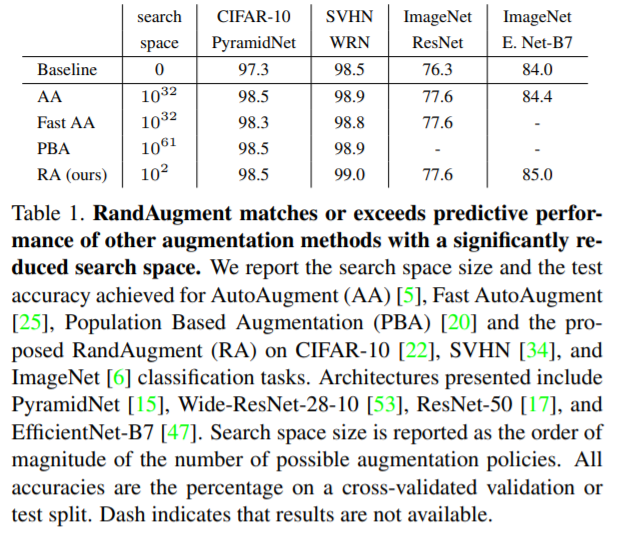

RandAugment는 parameter가 단 두개(N, M)맊게 없기 때문에 위의 표 Table 1을 보면 알 수 있듯이 다른 기법들보다 훨씬 search space가 훨씬 작다.

- N: Number of augmentation transformations to apply sequentially
- M: Magnitude for all the transformations

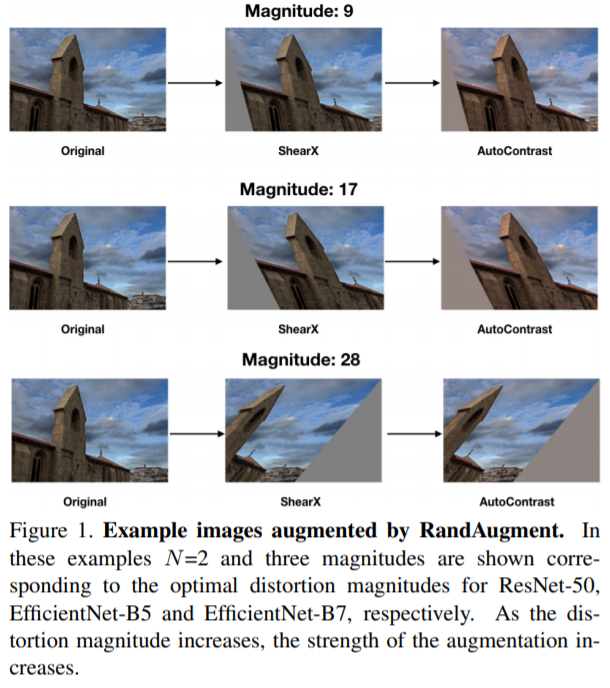

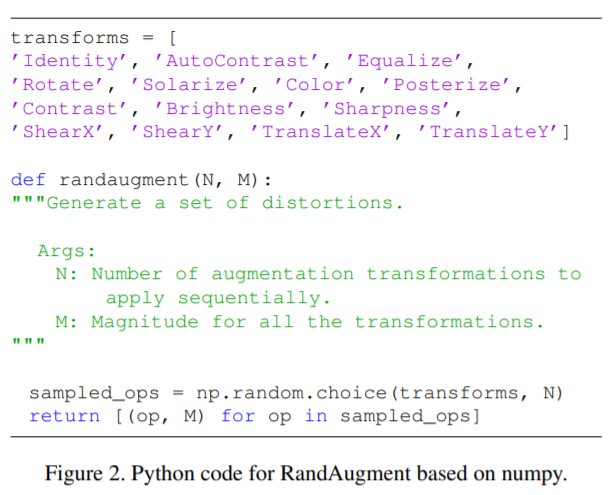

실제 적용 방법은 매우 간단한데 위의 그림 Figure 2는 numpy로 작성한 코드이다. 코드를 해석하자면, 랜덤으로 구성된 operation 선택 funtion이다. 모든 14개의 함수는 1/14 확률로 call된다.(=uniformly)

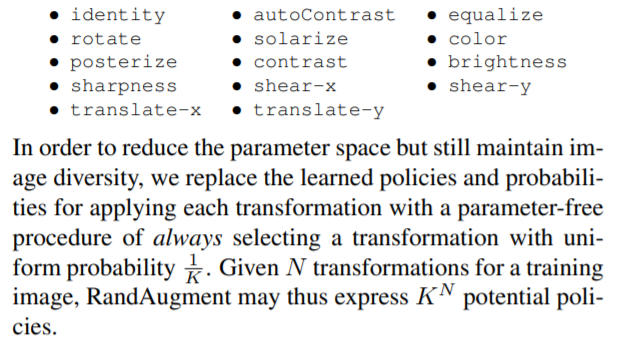

대상 operation 함수는 위와 같다. 흔히 사용이 되는 flip이 없는 것다.(개인적으로 이 부분이 신기했다.)

**Automated Augmentation은 증강 기법의 종류가 다양할수록 성능이 증가한다.** 하지만, 본 논문에서는 AutoAugmentation과의 비교를 위해 14개로 설정했다. (즉, 저 위의 14개가 가장 좋은 augmentation 선택인 것은 아니다.)

N: Number of augmentation transformations to apply sequentially. 매번 K개의 augmentation 기법들 중 동일한 확률(uniform) 1/K로 하나씩 무작위로 총 N번 골라 진행한다.

M: Magnitude for all the transformations. 이때 모든 변환에 대한 magnitude를 동일하게 적용한다. 즉, **separate search phase를 없앤다.** 각 변환은 magnitude의 min과 max를 정해두고 manitude를 1 ~ 10까지의 정수로 두어 그 상대적 세기를 동일하게 적용한다.

In [1]:
class RandAugment:
  # n: Number of augmentation transformations to apply sequentially
  # m: Magnitude for all the transformations
  def __init__(self, n, m):
    self.n = n
    self.m = m
    self.augment_list = augment_list()

  def __call__(self, img):
    ops = random.choices(self.augment_list, k=self.n)
    for op, minval, maxval in ops:
      val = (float(self.m) / 10) * float(maxval - minval) + minval
      img = op(img, val)

    return img

이를 코드로 나타내면 위와 같다.

## **Experiments**

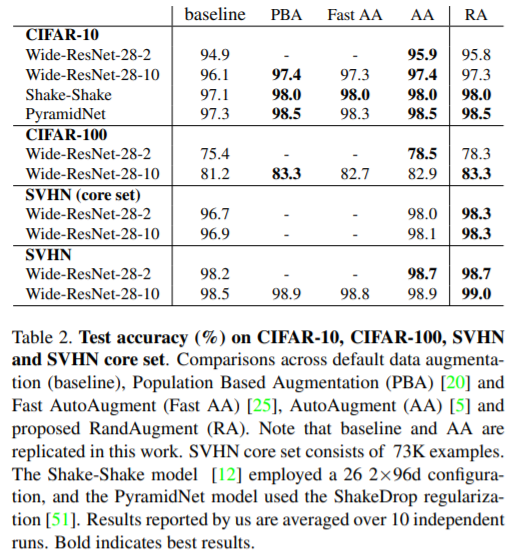

위의 표 Table 2는 CIFAR dataset과 SVHN으로 기존 AutoAugmentation과의 성능을 비교한 것이다. 성능면에서는 타 기법들과 크게 차이가 안난다.

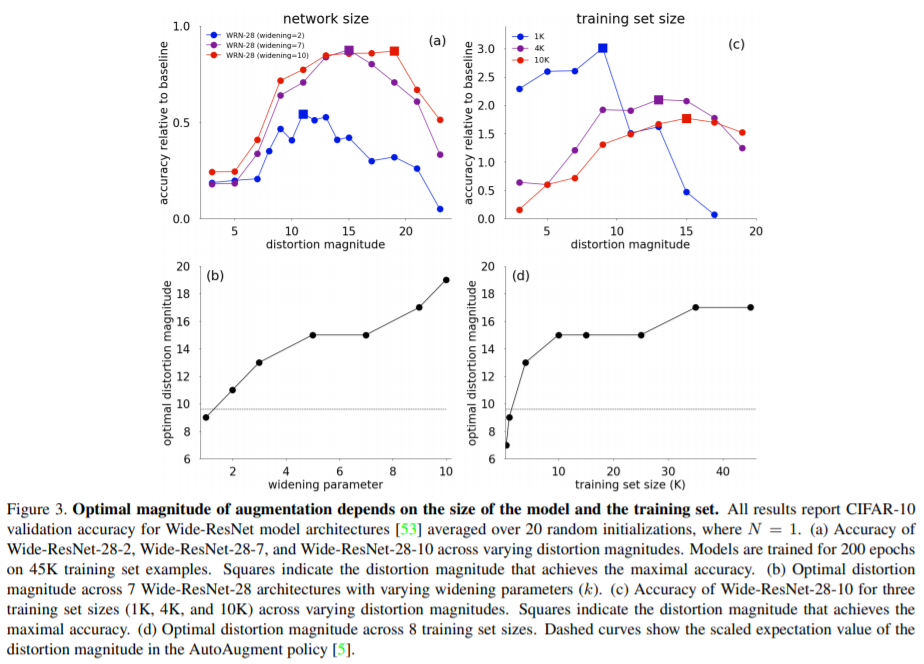

기존의 AA, FAA 등에선 augmentation된 결과를 dataset에 적용하기 위해 proxy task가 필수였다. (proxy task: 최적의 augmentation policy를 찾기 위한 원래의 학습대상인 큰 dataset에서 부분집합으로 구성한 작은 dataset을 가지고 최적화 작업을 진행하는 것을 의미) **이때 가정한 것이 있는데 바로 작은 dataset에서 결정한 policy가 큰 dataset에서도 효과적이라는 것이다.** 이를 시험하기 위해 위의 그림 Figure 3에서는 network size와 training set size를 변경하여 실험을 해봤다.

먼저, 위의 그림 Figure 3에서 (a) 부분을 보면 network의 size가 클수록 보상이 큰(acc가 높은) 것을 알 수 있으며, magnitude가 큰 값에서 결정됨을 알 수 있다. (b) 부분을 보면 좀 더 자세히 보기 위하여 최적 magnitude가 결정되는 구간을 WideResNet의 widening param을 이용하여 network size를 확인할 수 있다. (c) 부분을 보면 dataset의 크기가 클수록 magnitude가 커지는 것을 알 수 있다. 마지막으로 (d) 부분을 보면 dataset이 클수록 최적의 magnitude가 단조증가함을 알 수 있다.

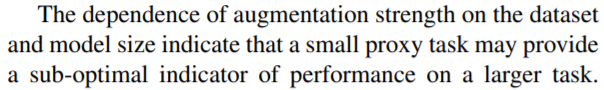

위의 내용을 한 마디로 정리하면 RA는 **network의 size가 클수록 보상이 크며 train dataset의 size가 클수로 보상이 적다.**

이는 즉, 기존 AutoAugment가 sub-optimal solution임을 나타낸다. 본 논문에서는 Augmentation은 부분 dataset에서 optimal solution을 찾아내고 이를 전체 dataset에 대한 optimal solution이라고 주장한다.

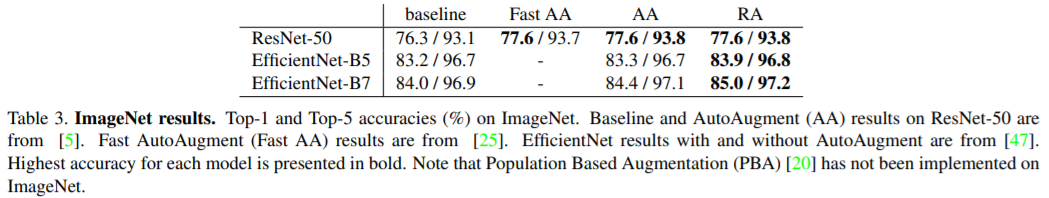

위의 표 Table 3는 ImageNet에 대해 타 기법들과 비교한 결과이다. RA는 위의 표에서 가장 작은 모델인 ResNet-50에서 AA와 FAA의 성능과 일치하지만 더 큰 모델의 경우는 RA가 타 기법들보다 성능이 최대 + 1.3 %까지 증가한다. (FAA의 경우는 아예 ImageNet에 대한 결과가 없는데, 고성능 GPU를 요구해서 그런거 같다......)

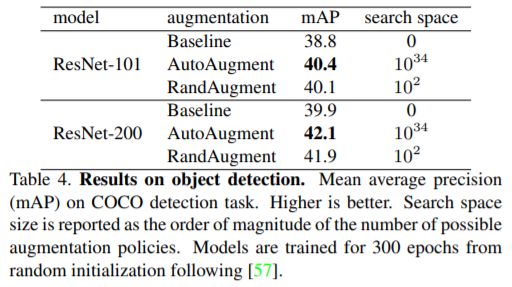

위의 표 Table 4는 COCO dataset으로 실험을 진행한 것이다. AA가 좀 더 우수한 결과를 보여줬지만, 위에서 봤듯이 search space로 인한 효율성을 생각해보면 mAP 값이 그렇게 크게 의미있어 보이지는 않는다.

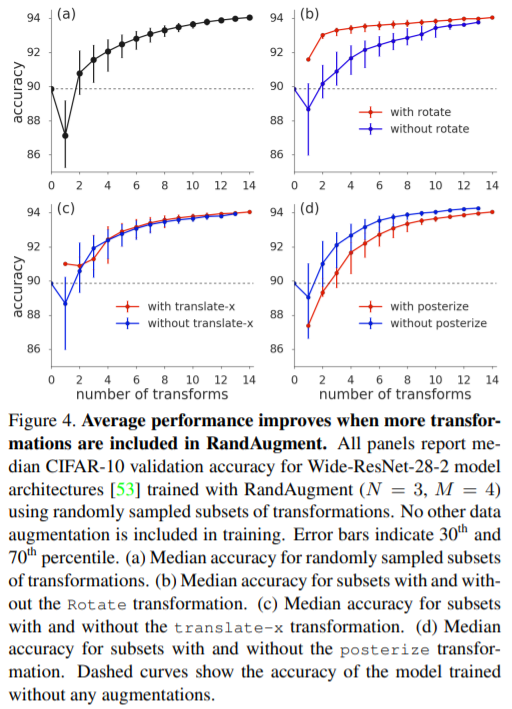

위의 그림 Figure 4를 통해 더 많은 augmentation을 추가시 성능이 좋아지는 것을 알 수 있다.

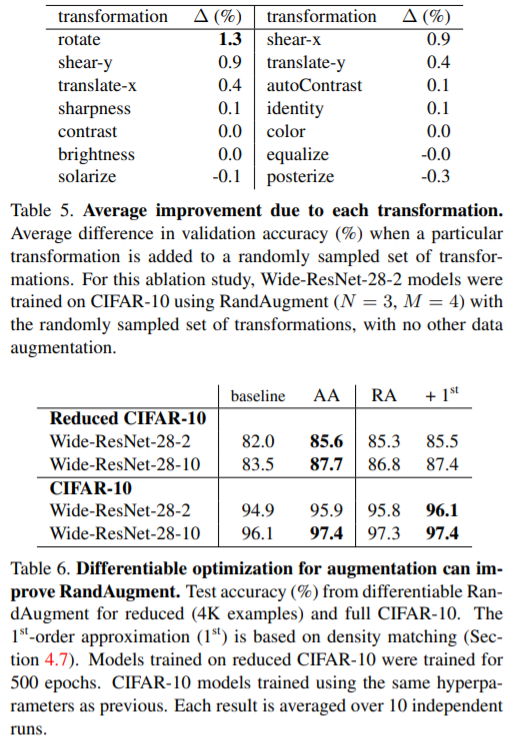

위의 표 Table 5는 어떤 transformation이 성능이 어떻게 되는지 보여준다. rotation이 제일 우수하며, posterize가 가장 낮은 성능을 보여주는 것을 확인할 수 있다. 그리고 Table 6에서는 Differentiable optimization을 통해 성능을 향상시킬 수 있다는 것을 보여준다.